Summary Statistics:
╒═══════════════════════════════════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════╤═════════╤═══════════╤══════════════════╕
│ Department                                    │   count │        mean │         std │     min │       25% │     50% │       75% │              max │
╞═══════════════════════════════════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════╪═════════╪═══════════╪══════════════════╡
│ Year                                          │      47 │    1999     │     13.7113 │    1976 │    1987.5 │    1999 │   2010.5  │   2022           │
├───────────────────────────────────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────┼─────────┼───────────┼──────────────────┤
│ Corps of Engineers                            │      47 │    4804.21  │   2620.54   │    2177 │    3220.5 │    4145 │   5197.5  │  16587           │
├───────────────────────────────────────────────┼─────────┼─────────────┼─

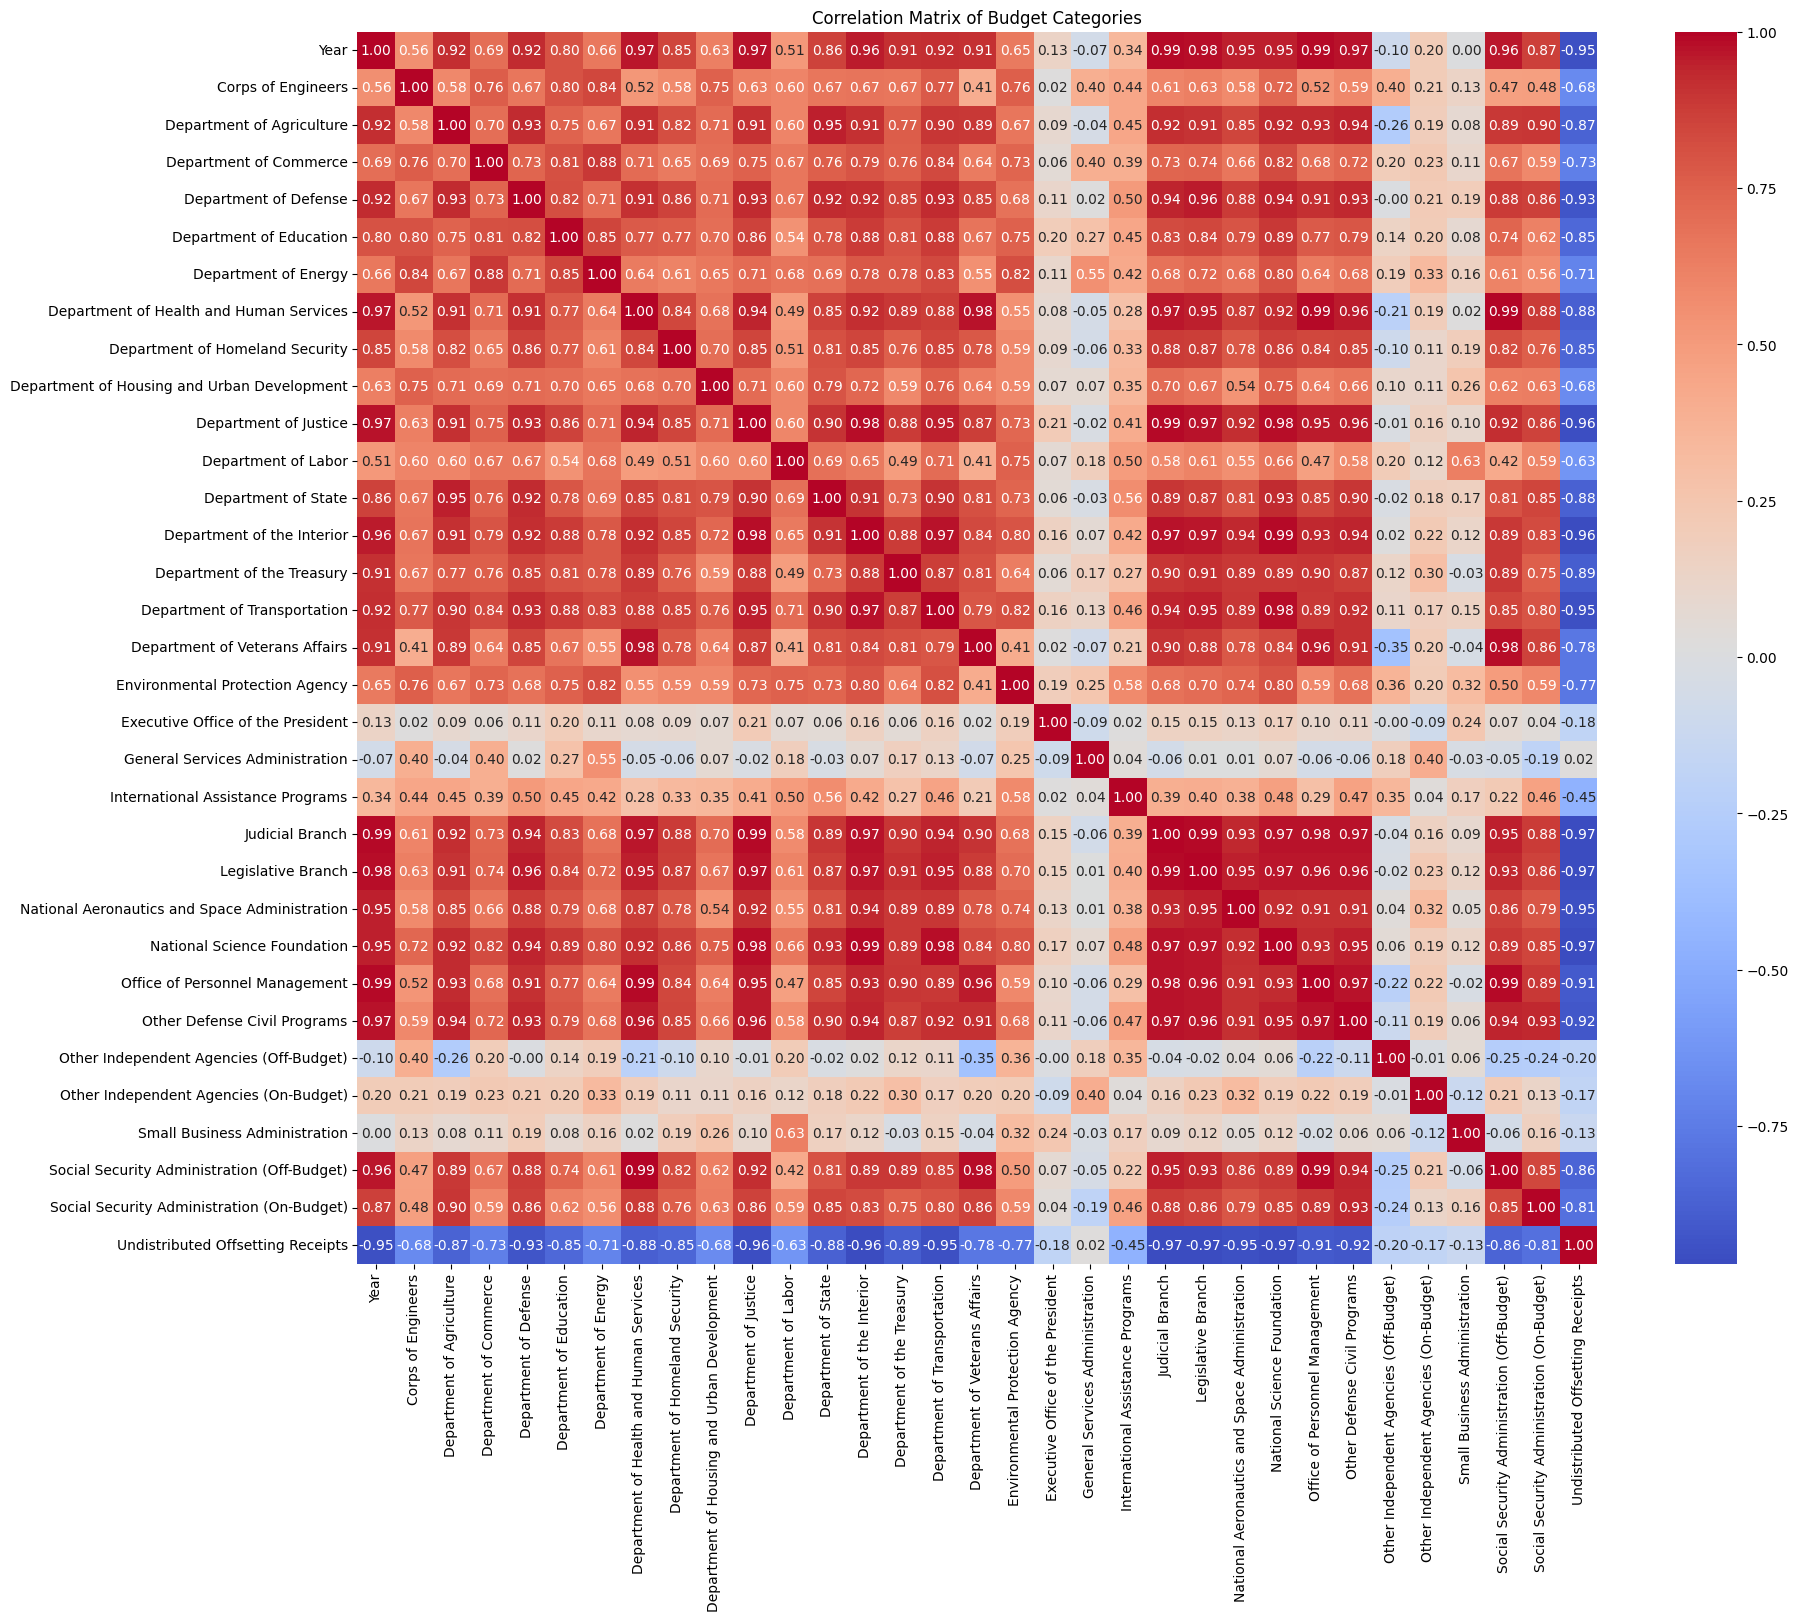

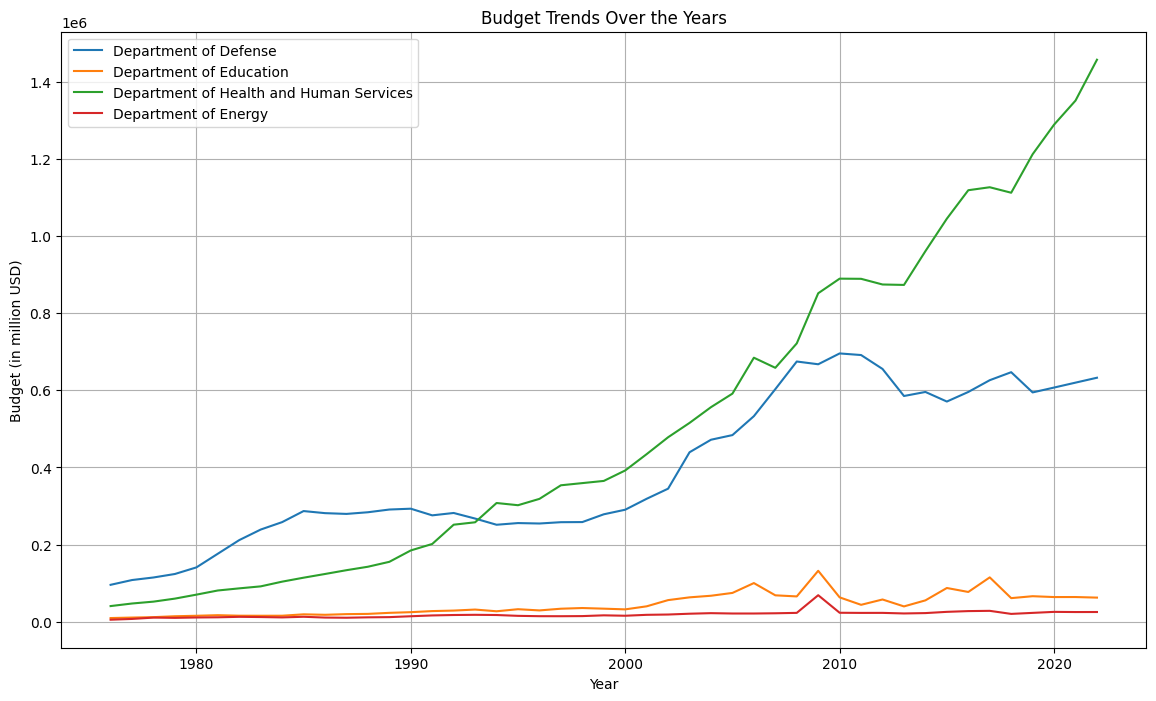

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate  # For displaying data in a table format

# Load the dataset
budget_file_path = '/content/budget.csv'
df = pd.read_csv(budget_file_path)

# Summary statistics transposed
budget_summary_statistics = df.describe().T
budget_summary_statistics = budget_summary_statistics.rename_axis("Department").reset_index()

# Convert the DataFrame to a table format using tabulate
table = tabulate(
    budget_summary_statistics,
    headers="keys",
    tablefmt="fancy_grid",
    showindex=False
)

# Print the table
print("Summary Statistics:")
print(table)

# Correlation matrix
budget_correlation_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(budget_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Budget Categories")
plt.show()

# Plotting trends for selected budgets over the years
selected_columns = [
    "Department of Defense",
    "Department of Education",
    "Department of Health and Human Services",
    "Department of Energy",
]

plt.figure(figsize=(14, 8))
for column in selected_columns:
    plt.plot(df["Year"], df[column], label=column)

plt.title("Budget Trends Over the Years")
plt.xlabel("Year")
plt.ylabel("Budget (in million USD)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from typing import Dict, List, Tuple

class BudgetForecaster:
    def __init__(self, data_path: str, window_size: int = 5):
        self.df = pd.read_csv(data_path)
        self.window_size = window_size
        self.prepare_data()

    def create_sequences(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Create sequences for time series prediction"""
        X, y = [], []
        for i in range(len(data) - self.window_size):
            X.append(data[i:(i + self.window_size)])
            y.append(data[i + self.window_size])
        return np.array(X), np.array(y)

    def prepare_data(self):
        """Prepare the dataset for analysis"""
        # Handle missing values first
        self.dept_columns = [col for col in self.df.columns if col != 'Year']
        self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='ffill')

        # Print info about NaN values
        print("\nMissing values before cleaning:")
        print(self.df[self.dept_columns].isna().sum())

        # First fill backwards (for any missing values at the start)
        self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='bfill')
        # Then fill forward (for any remaining gaps)
        self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='ffill')
        # Any remaining NaNs (if both ends have NaNs) fill with 0
        self.df[self.dept_columns] = self.df[self.dept_columns].fillna(0)

        print("\nMissing values after cleaning:")
        print(self.df[self.dept_columns].isna().sum())

        # Create sequences for all departments
        data = self.df[self.dept_columns].values
        X, y = self.create_sequences(data)

        # Get corresponding years for the sequences
        sequence_years = self.df['Year'].values[self.window_size:]  # years corresponding to y values

        # Now split based on years (2010-2020 for training, 2021-2022 for testing)
        train_mask = (sequence_years <= 2020) & (sequence_years >= 2010)
        test_mask = sequence_years > 2020

        self.X_train = X[train_mask]
        self.y_train = y[train_mask]
        self.X_test = X[test_mask]
        self.y_test = y[test_mask]

        # Store years for plotting
        self.train_years = sequence_years[train_mask]
        self.test_years = sequence_years[test_mask]

        print(f"Training samples: {len(self.X_train)} (Years: {self.train_years[0]} to {self.train_years[-1]})")
        print(f"Testing samples: {len(self.X_test)} (Years: {self.test_years[0]} to {self.test_years[-1]})")
        print(f"Each sample uses {self.window_size} previous years to predict the next year")

    def train_and_predict(self) -> Dict:
        """Train all models and generate predictions"""
        predictions = {}

        # 1. Linear Regression
        lr = LinearRegression()
        # Reshape X for LinearRegression (samples, window_size * features)
        X_train_reshaped = self.X_train.reshape(self.X_train.shape[0], -1)
        X_test_reshaped = self.X_test.reshape(self.X_test.shape[0], -1)
        lr.fit(X_train_reshaped, self.y_train)
        predictions['Linear'] = lr.predict(X_test_reshaped)

        # 2. Naive Forecast (using last window value)
        predictions['Naive'] = self.X_test[:, -1, :]

        # 3. Exponential Smoothing
        exp_predictions = []
        for col_idx, dept in enumerate(self.dept_columns):
            # Use the time series up to 2020 for Exponential Smoothing
            train_series = self.df.loc[self.df['Year'] <= 2020, dept].values
            model = ExponentialSmoothing(
                train_series,
                trend='add',
                seasonal=None
            ).fit()
            exp_predictions.append(model.forecast(len(self.test_years)))
        predictions['Exponential'] = np.array(exp_predictions).T

        # 4. ARIMA
        arima_predictions = []
        for col_idx, dept in enumerate(self.dept_columns):
            # Use the time series up to 2020 for ARIMA
            train_series = self.df.loc[self.df['Year'] <= 2020, dept].values
            model = sm.tsa.ARIMA(train_series, order=(1, 1, 1)).fit()
            arima_predictions.append(model.forecast(len(self.test_years)))
        predictions['ARIMA'] = np.array(arima_predictions).T

        return predictions

    def evaluate_models(self, predictions: Dict) -> pd.DataFrame:
        """Calculate evaluation metrics for all models"""
        results = []

        for model_name, pred in predictions.items():
            mse = mean_squared_error(self.y_test, pred, multioutput='raw_values')
            mae = mean_absolute_error(self.y_test, pred, multioutput='raw_values')

            for idx, col in enumerate(self.dept_columns):
                results.append({
                    'Model': model_name,
                    'Department': col,
                    'MSE': mse[idx],
                    'MAE': mae[idx]
                })

        return pd.DataFrame(results)

    def plot_predictions(self, predictions: Dict, top_n: int = 6):
        """Plot actual vs predicted values for top departments"""
        # Get top departments by budget
        top_depts = self.df[self.dept_columns].mean().nlargest(top_n).index

        fig, axes = plt.subplots(top_n // 2, 2, figsize=(20, 5 * (top_n // 2)))
        axes = axes.ravel()

        colors = {'Linear': 'red', 'Naive': 'green',
                 'Exponential': 'purple', 'ARIMA': 'orange'}

        for idx, dept in enumerate(top_depts):
            ax = axes[idx]
            dept_idx = self.dept_columns.index(dept)

            # Plot training data
            ax.plot(self.train_years,
                   self.y_train[:, dept_idx],
                   'b-o',
                   label='Training Data')

            # Plot test data
            ax.plot(self.test_years,
                   self.y_test[:, dept_idx],
                   'b--o',
                   label='Actual Test Data')

            # Plot predictions for each model
            for model_name, preds in predictions.items():
                ax.plot(self.test_years,
                       preds[:, dept_idx],
                       '--x',
                       color=colors[model_name],
                       label=f'{model_name} Prediction')

            ax.set_title(f'{dept} Budget Forecast')
            ax.set_xlabel('Year')
            ax.set_ylabel('Budget Value')
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.tight_layout()
        plt.show()

# Run the analysis
forecaster = BudgetForecaster('/content/budget.csv', window_size=5)


Missing values before cleaning:
Corps of Engineers                               0
Department of Agriculture                        0
Department of Commerce                           0
Department of Defense                            0
Department of Education                          0
Department of Energy                             0
Department of Health and Human Services          0
Department of Homeland Security                  0
Department of Housing and Urban Development      0
Department of Justice                            0
Department of Labor                              0
Department of State                              0
Department of the Interior                       0
Department of the Treasury                       0
Department of Transportation                     0
Department of Veterans Affairs                   0
Environmental Protection Agency                  0
Executive Office of the President                0
General Services Administration                  

<ipython-input-27-fa58a16e0173>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='ffill')
<ipython-input-27-fa58a16e0173>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='bfill')
<ipython-input-27-fa58a16e0173>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[self.dept_columns] = self.df[self.dept_columns].fillna(method='ffill')


In [ ]:
# Train models and get predictions
print("\nTraining models and generating predictions...")
predictions = forecaster.train_and_predict()


Training models and generating predictions...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

In [ ]:
# Evaluate models
print("\nEvaluating model performance...")
results_df = forecaster.evaluate_models(predictions)

# Get top departments
top_n = 6  # or whatever number you want
top_depts = forecaster.df[forecaster.dept_columns].mean().nlargest(top_n)

# Filter results_df to only show metrics for top departments
top_dept_results = results_df[results_df['Department'].isin(top_depts.index)]

# Sort performance metrics
sorted_metrics = top_dept_results.sort_values(['Department', 'MSE'])

# Display sorted performance metrics as a table
print("\nModel Performance Metrics for Top Departments:")
print(tabulate(sorted_metrics, headers='keys', tablefmt='fancy_grid', showindex=False))



Evaluating model performance...

Model Performance Metrics for Top Departments:
╒═════════════╤═════════════════════════════════════════════╤══════════════════╤════════════╕
│ Model       │ Department                                  │              MSE │        MAE │
╞═════════════╪═════════════════════════════════════════════╪══════════════════╪════════════╡
│ Naive       │ Department of Agriculture                   │      2.40214e+06 │   1509.5   │
├─────────────┼─────────────────────────────────────────────┼──────────────────┼────────────┤
│ Linear      │ Department of Agriculture                   │      3.01464e+06 │   1716.83  │
├─────────────┼─────────────────────────────────────────────┼──────────────────┼────────────┤
│ ARIMA       │ Department of Agriculture                   │      6.09772e+06 │   2398.17  │
├─────────────┼─────────────────────────────────────────────┼──────────────────┼────────────┤
│ Exponential │ Department of Agriculture                   │      4.9793


Plotting predictions for top departments...


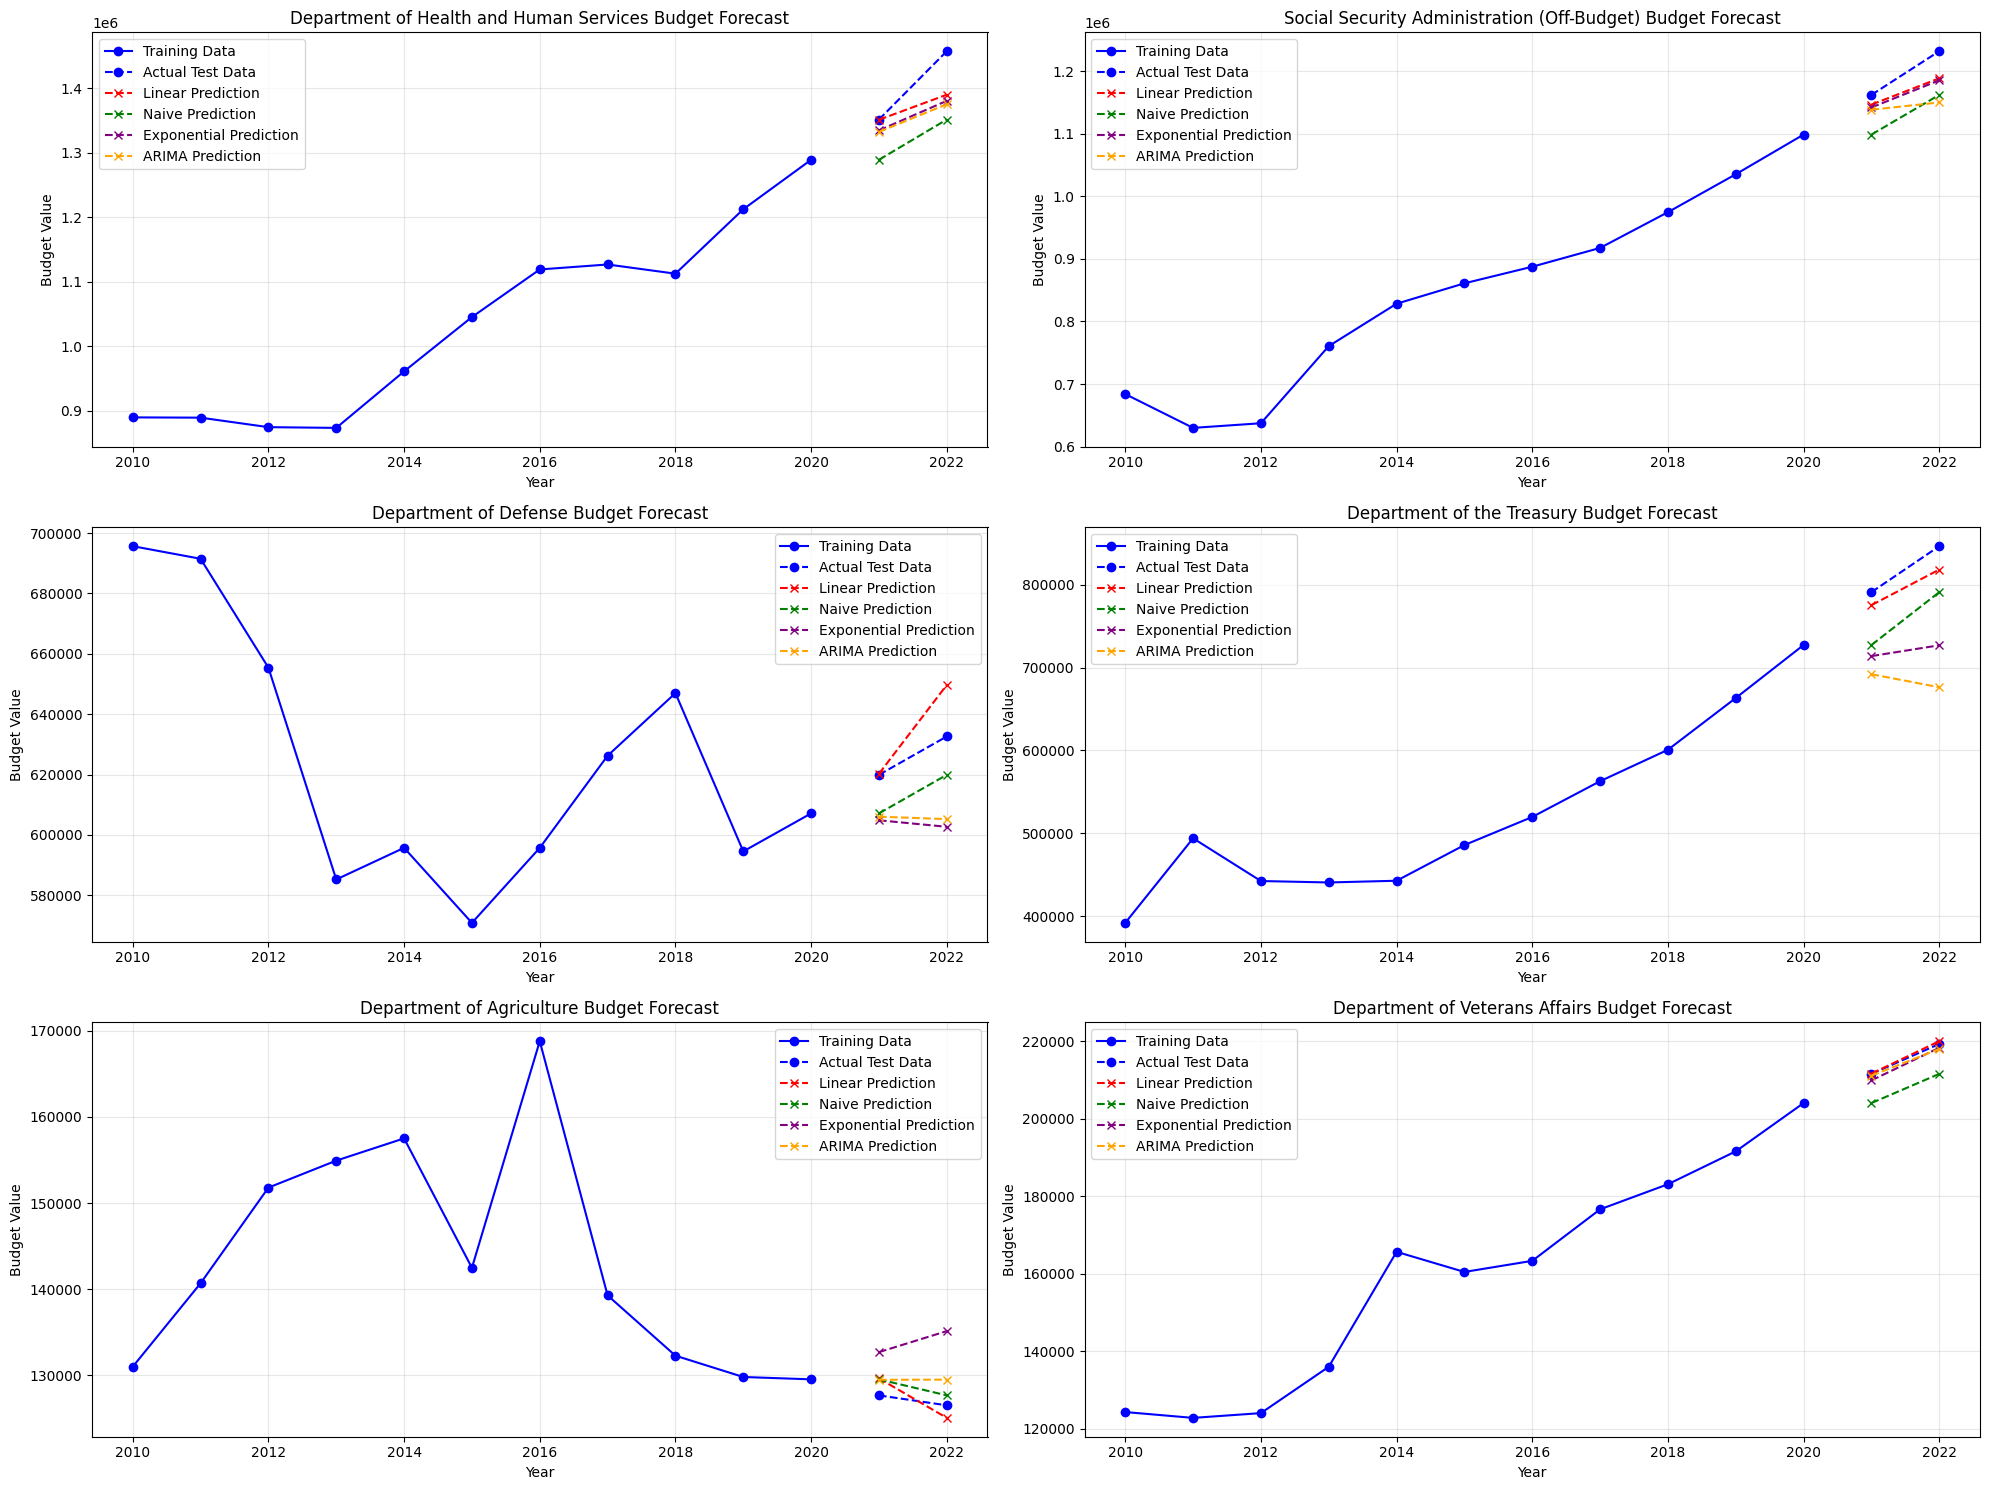

In [ ]:
# Plot predictions for top departments
print("\nPlotting predictions for top departments...")
forecaster.plot_predictions(predictions)